### Análisis Exploratorio 


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm


In [68]:
sns.set_style("whitegrid")
train_df = pd.read_csv("train.csv")

In [69]:
print("Información general del dataset:")
train_df.info()

print("\nResumen estadístico:")
print(train_df.describe())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460

In [70]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nValores nulos por columna:")
print(missing_values)


Valores nulos por columna:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [71]:
# Llenar valores nulos en variables categóricas con "None"
categorical_features = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                        "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
# Llenar valores nulos en variables categóricas con "None"
train_df[categorical_features] = train_df[categorical_features].fillna("None")

numerical_features = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]

# Llenar valores nulos en variables numéricas con la mediana
train_df[numerical_features] = train_df[numerical_features].apply(lambda x: x.fillna(x.median()))
    


In [72]:
# Aplicar logaritmo al precio de venta para normalizar
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Convertir variables categóricas en numéricas con Label Encoding de forma vectorizada
label_encoders = {col: LabelEncoder().fit(train_df[col]) for col in categorical_features}
train_df[categorical_features] = train_df[categorical_features].apply(lambda col: label_encoders[col.name].transform(col))


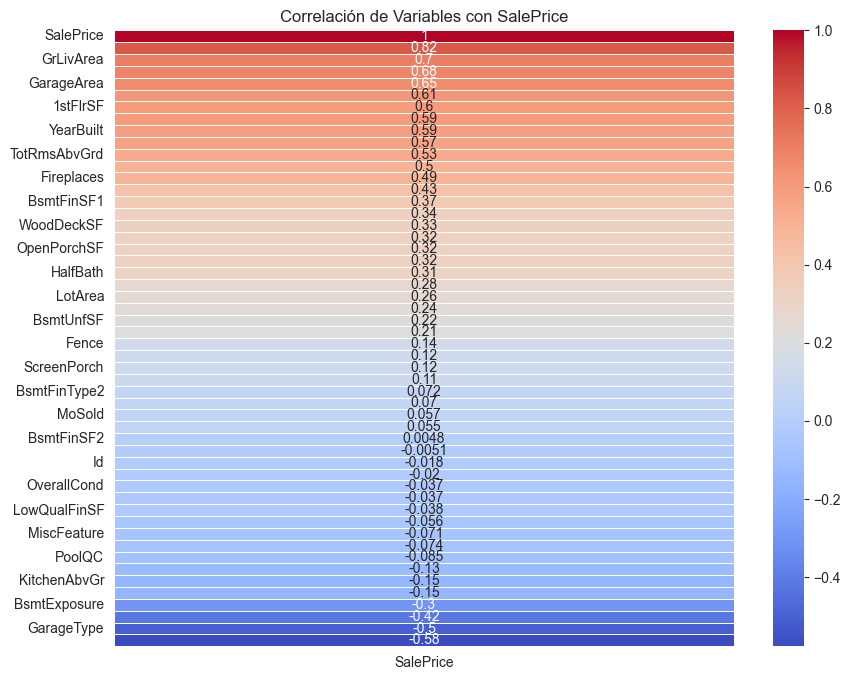

In [73]:
#4. ANÁLISIS DE CORRELACIÓN
plt.figure(figsize=(10, 8))
corr_matrix = train_df.corr(numeric_only=True)
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False), 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlación de Variables con SalePrice")
plt.show()

El análisis de correlación muestra qué variables tienen mayor impacto en el precio de las casas. Se observa que GrLivArea (Área habitable sobre el suelo) tiene la correlación más alta con SalePrice (0.72), seguida de GarageArea (0.68) y 1stFlrSF (0.61), lo que indica que el tamaño de la vivienda y el área del garaje son factores determinantes en el precio. Variables como YearBuilt (0.59) sugieren que las casas más nuevas tienden a ser más caras. En contraste, variables como GarageType (-0.38) y BsmtExposure (-0.15) tienen correlaciones negativas, indicando que podrían afectar el precio de manera inversa. Este análisis permite identificar qué variables son más relevantes para la predicción del precio y cuáles pueden ser descartadas o transformadas en el modelo.

In [74]:
correlation_threshold = 0.5
strong_corr_vars = corr_matrix["SalePrice"].abs().sort_values(ascending=False)
strong_corr_vars = strong_corr_vars[strong_corr_vars > correlation_threshold]
print("Variables con mayor correlación con SalePrice:")
print(strong_corr_vars)

Variables con mayor correlación con SalePrice:
SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
BsmtQual        0.576969
YearRemodAdd    0.565608
TotRmsAbvGrd    0.534422
GarageType      0.503129
Name: SalePrice, dtype: float64


El análisis de correlación muestra que las variables con mayor impacto en el precio de las casas (SalePrice) son OverallQual (0.82), GrLivArea (0.71) y GarageCars (0.68), lo que indica que la calidad general de la construcción, el tamaño habitable y la capacidad del garaje son factores clave en la determinación del precio. También se destacan TotalBsmtSF (0.61) y 1stFlrSF (0.60), lo que sugiere que el tamaño del sótano y del primer piso son importantes para la valuación. La presencia de YearBuilt (0.58) y YearRemodAdd (0.56) implica que las casas más nuevas o remodeladas suelen tener precios más altos. 

In [75]:
# 5. DIVISIÓN DEL DATASET 
X = train_df.drop(columns=["SalePrice", "Id"])
y = train_df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de los conjuntos de datos:")
print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")



Tamaño de los conjuntos de datos:
Entrenamiento: (1168, 79), Prueba: (292, 79)


La división del dataset se realizó separando el conjunto de datos en entrenamiento (80%) y prueba (20%). El conjunto de entrenamiento contiene 1,168 muestras con 79 variables, mientras que el de prueba cuenta con 292 muestras con las mismas características. Se utilizó 'random_state=42' para garantizar la reproducibilidad de los resultados, permitiendo que la misma partición se mantenga en cada ejecución. Esta división permite evaluar el rendimiento de los modelos de predicción en datos no vistos antes, validando su capacidad de generalización.

In [76]:
categorical_features = X_train.select_dtypes(include=['object']).columns

column_transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='passthrough' 
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

X_train_transformed = pd.DataFrame(X_train_transformed, columns=column_transformer.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_transformer.get_feature_names_out())

print("Transformación de datos completada correctamente")

print("Preprocesamiento completado")

Transformación de datos completada correctamente
Preprocesamiento completado


En esta parte del código se realiza el preprocesamiento de los datos, transformando las variables categóricas en un formato numérico mediante la técnica de One-Hot Encoding. Primero, se identifican las variables categóricas dentro del conjunto de entrenamiento y se aplica un 'ColumnTransformer' que convierte estas variables en representaciones binarias, asegurando que todas las características sean compatibles con los modelos de machine learning. El parámetro 'handle_unknown='ignore'' permite que la transformación ignore categorías no vistas en los datos de prueba, evitando errores. Finalmente, los datos transformados se convierten nuevamente en 'DataFrame' con nombres de columnas adecuados para facilitar su interpretación y uso en los modelos. 

# Análisis de relaciones con la variable respuesta

### Análisis de Relación con Gráficos de Dispersión

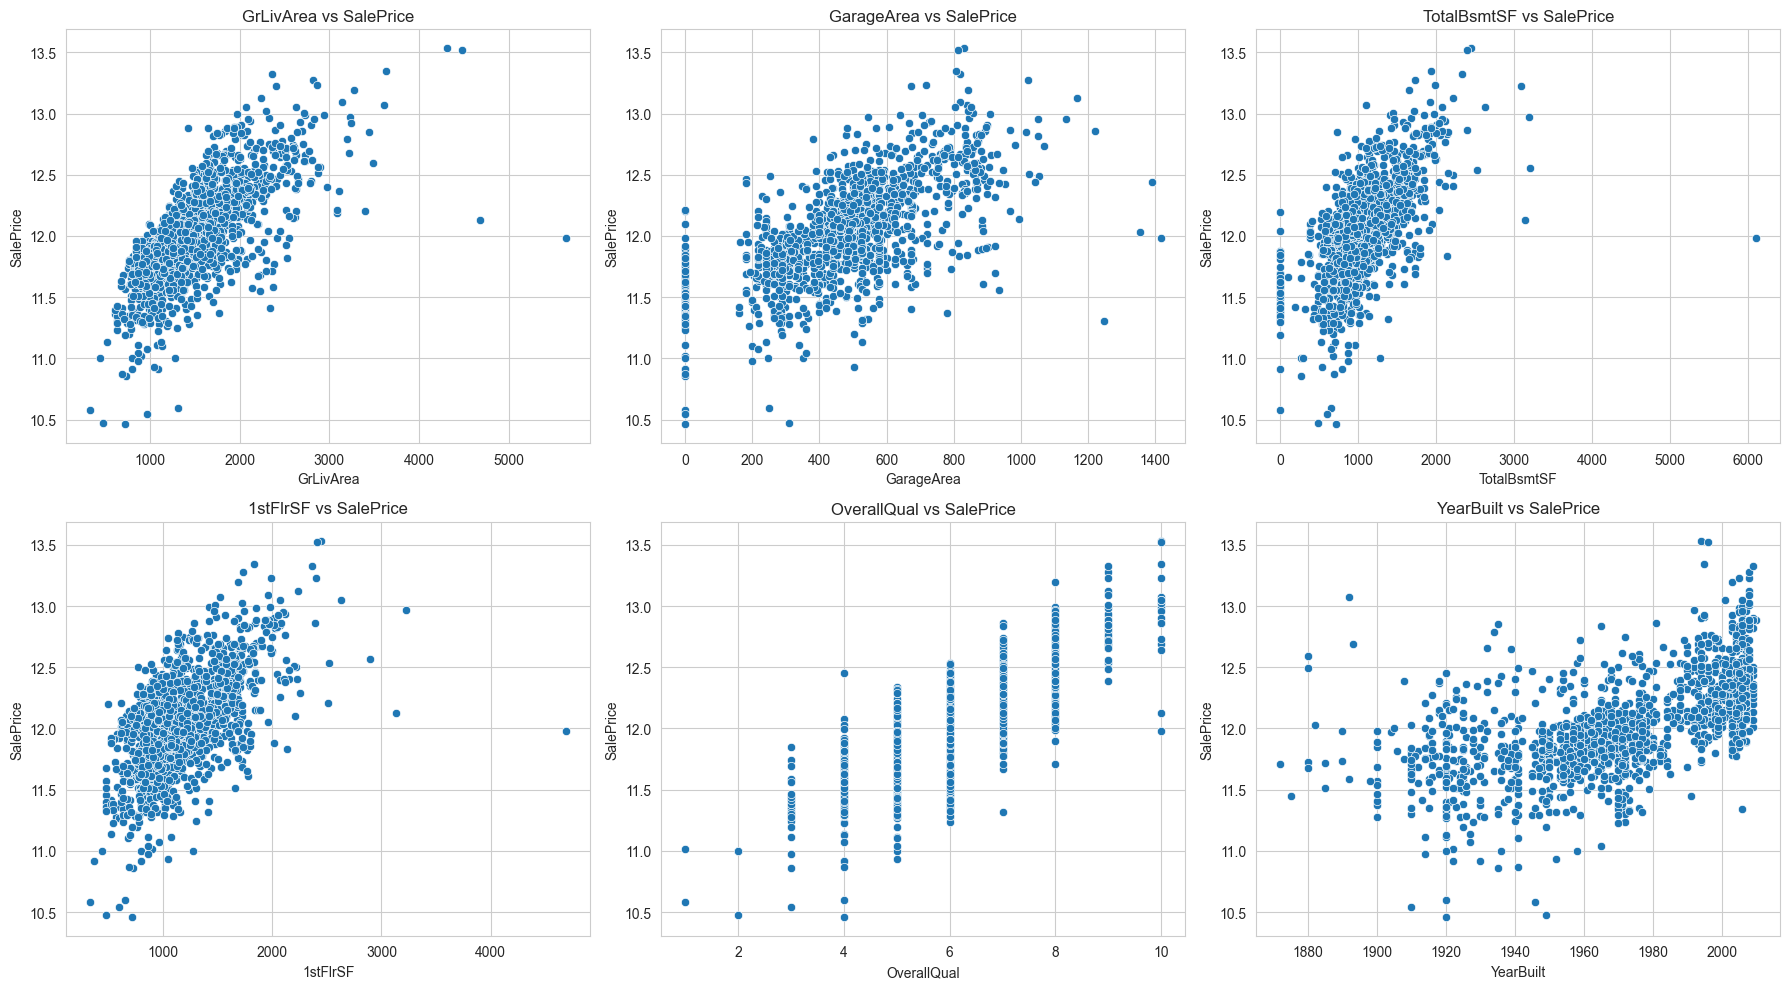

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  

top_vars = ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "OverallQual", "YearBuilt"]

for var, ax in zip(top_vars, axes):
    sns.scatterplot(x=train_df[var], y=train_df["SalePrice"], ax=ax)
    ax.set_title(f"{var} vs SalePrice")

plt.tight_layout()
plt.show()


### Análisis de Relación con Boxplots

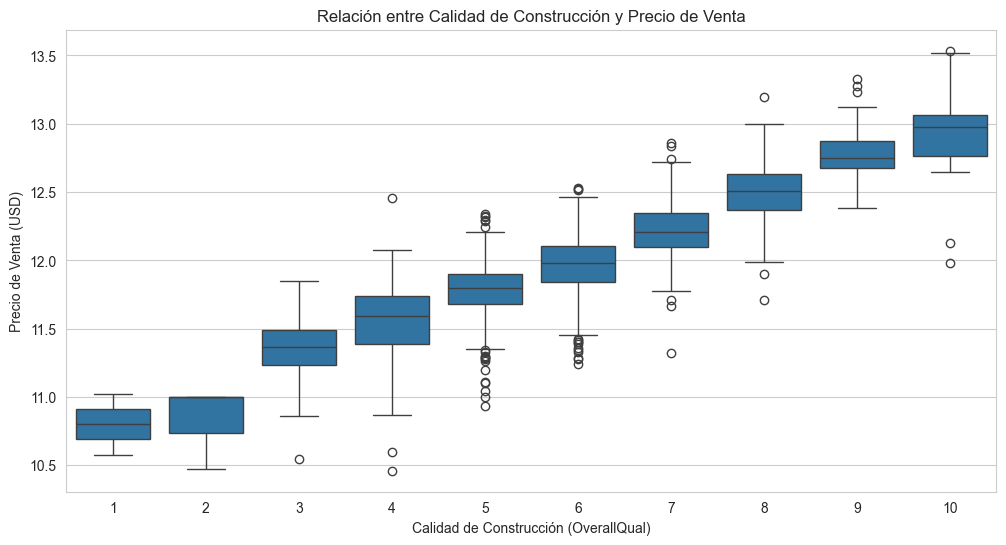

In [78]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_df["OverallQual"], y=train_df["SalePrice"])
plt.xlabel("Calidad de Construcción (OverallQual)")
plt.ylabel("Precio de Venta (USD)")
plt.title("Relación entre Calidad de Construcción y Precio de Venta")
plt.show()

### Regresión Lineal para evaluar impacto de variables

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Crear y entrenar el modelo en un pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regression", LinearRegression())
])

pipeline.fit(X_train_transformed, y_train)
# Obtener coeficientes de regresión
coef_dict = dict(zip(X.columns, pipeline.named_steps["regression"].coef_))

print("\nCoeficientes de la regresión lineal:")
for var, coef in coef_dict.items():
    print(f"{var}: {coef:.2f}")



Coeficientes de la regresión lineal:
MSSubClass: -0.02
MSZoning: 0.01
LotFrontage: 0.00
LotArea: 0.00
Street: -0.01
Alley: -0.00
LotShape: 0.00
LandContour: -0.00
Utilities: 0.01
LotConfig: 0.00
LandSlope: -0.00
Neighborhood: -0.01
Condition1: 0.00
Condition2: -0.00
BldgType: 0.00
HouseStyle: 0.00
OverallQual: -0.00
OverallCond: 0.00
YearBuilt: 0.01
YearRemodAdd: -0.01
RoofStyle: -0.01
RoofMatl: -0.00
Exterior1st: 0.00
Exterior2nd: 0.00
MasVnrType: -0.00
MasVnrArea: 0.00
ExterQual: -0.00
ExterCond: -0.01
Foundation: 0.01
BsmtQual: 0.00
BsmtCond: -0.00
BsmtExposure: 0.02
BsmtFinType1: -0.01
BsmtFinSF1: -0.00
BsmtFinType2: -0.00
BsmtFinSF2: -0.02
BsmtUnfSF: -0.01
TotalBsmtSF: -0.01
Heating: 0.00
HeatingQC: -0.01
CentralAir: 0.01
Electrical: 0.02
1stFlrSF: -0.00
2ndFlrSF: 0.00
LowQualFinSF: -0.00
GrLivArea: -0.00
BsmtFullBath: 0.00
BsmtHalfBath: 0.02
FullBath: 0.00
HalfBath: 0.01
BedroomAbvGr: -0.01
KitchenAbvGr: -0.00
KitchenQual: 0.01
TotRmsAbvGrd: -0.00
Functional: 0.00
Fireplaces: -0

### Árbol de Decisión para relaciones no lineales

C:\Users\Eduar\AppData\Local\Temp\ipykernel_3564\396496330.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df["Feature"], y=importance_df["Importance"], palette="Blues_r")


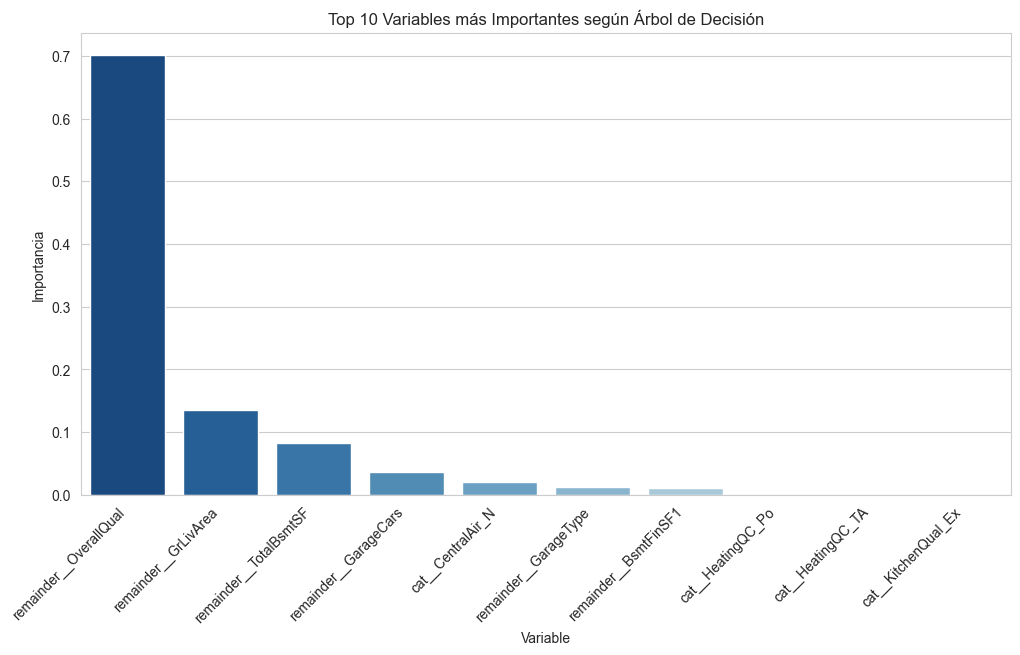

In [80]:
tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X_train_transformed, y_train)

importances = tree.feature_importances_
feature_names = X_train_transformed.columns

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df["Feature"], y=importance_df["Importance"], palette="Blues_r")

plt.xticks(rotation=45, ha="right") 
plt.title("Top 10 Variables más Importantes según Árbol de Decisión")
plt.xlabel("Variable")
plt.ylabel("Importancia")
plt.show()


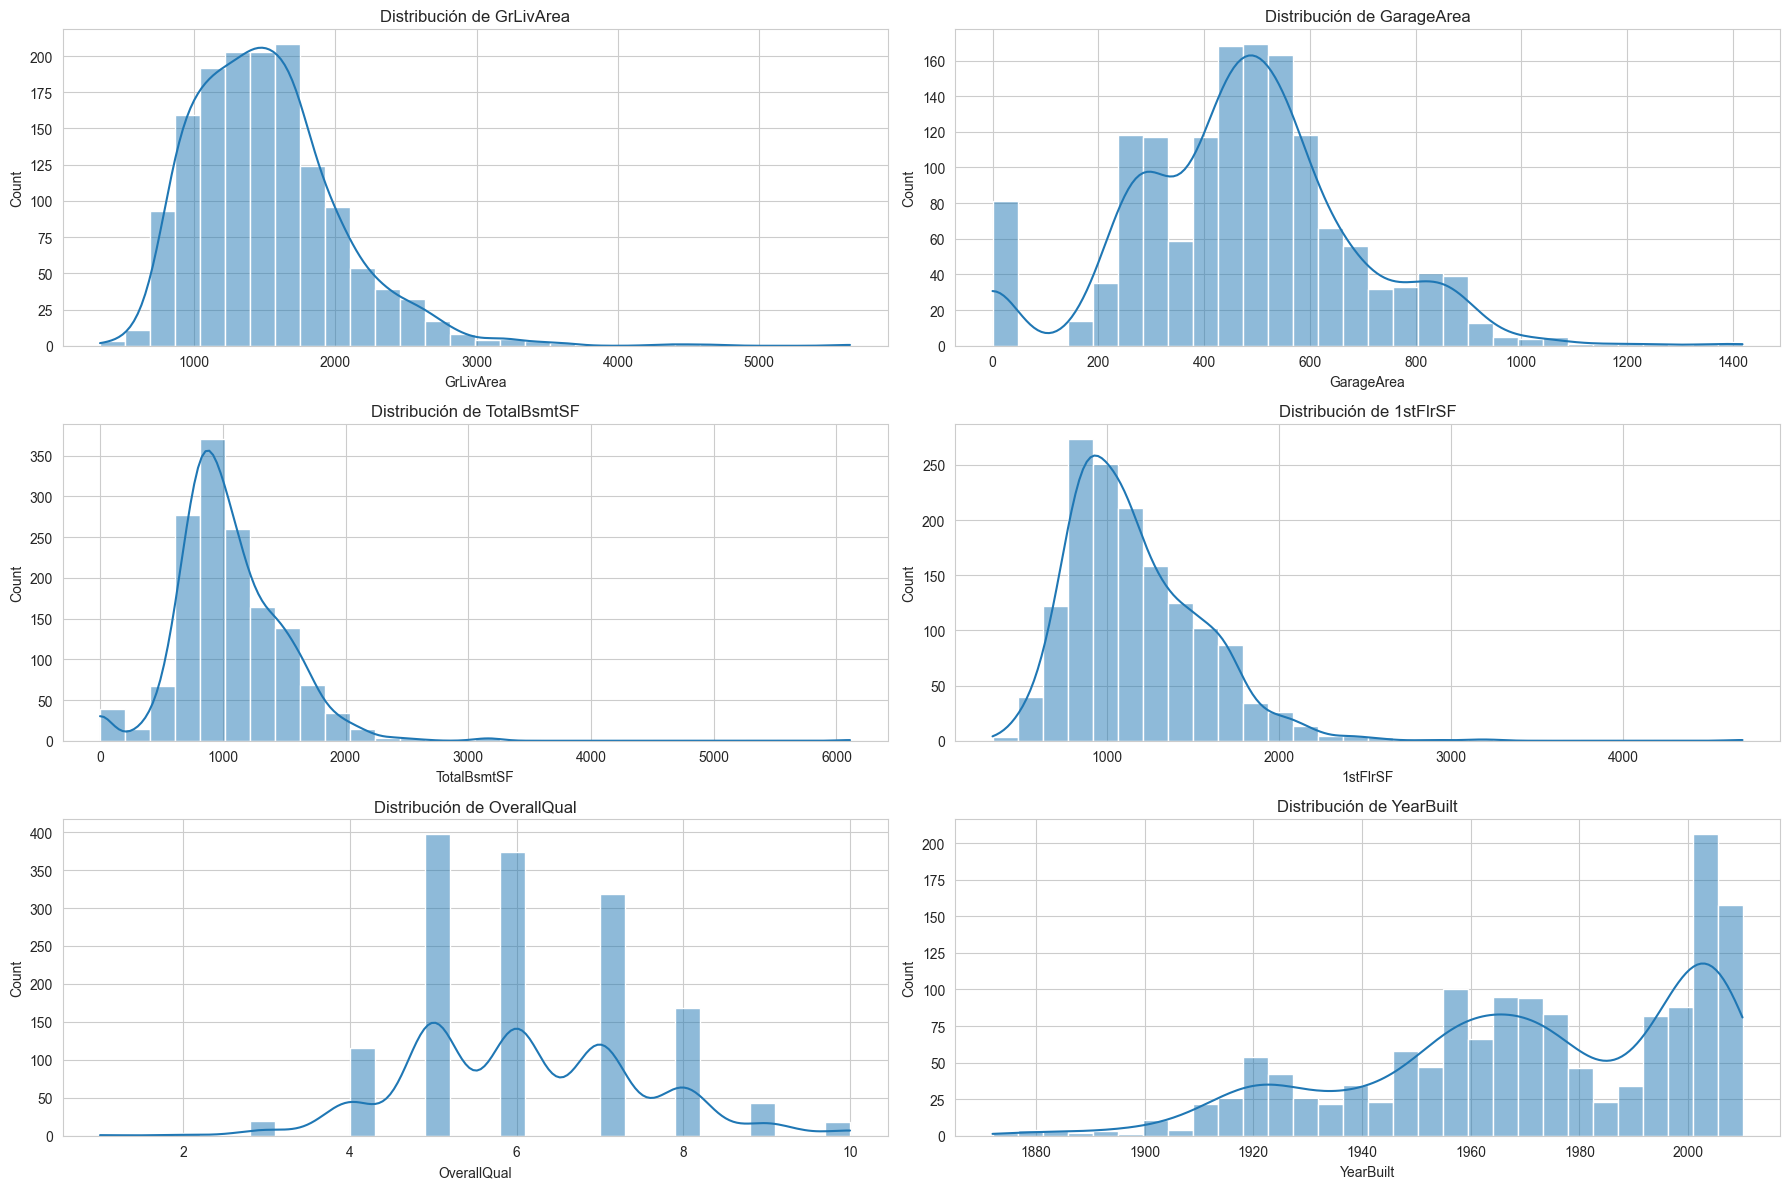

In [81]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()
top_vars = ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "OverallQual", "YearBuilt"]

for var, ax in zip(top_vars, axes):
    sns.histplot(train_df[var], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribución de {var}')
    
plt.tight_layout()
plt.show()


In [82]:
def evaluar_modelo(modelo, X_test_transformed, y_test, nombre_modelo):
    y_pred = modelo.predict(X_test_transformed)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"{nombre_modelo} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
evaluar_modelo(pipeline, X_test_transformed, y_test, "Regresión Lineal")
evaluar_modelo(tree, X_test_transformed, y_test, "Árbol de Decisión")

Regresión Lineal - R2: 0.9167, RMSE: 0.1246, MAE: 0.0883
Árbol de Decisión - R2: 0.7703, RMSE: 0.2070, MAE: 0.1556


In [83]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_transformed, y_train)

evaluar_modelo(rf, X_test_transformed, y_test, "Random Forest")

Random Forest - R2: 0.8845, RMSE: 0.1468, MAE: 0.0997


In [84]:
svr = SVR(kernel='rbf', C=100, gamma=0.1)
svr.fit(X_train_transformed, y_train)

evaluar_modelo(svr, X_test_transformed, y_test, "SVR")

SVR - R2: -0.0069, RMSE: 0.4335, MAE: 0.3371


In [85]:
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train_transformed, y_train)

evaluar_modelo(poly_model, X_test_transformed, y_test, "Regresión Polinomial")

Regresión Polinomial - R2: -1.4744, RMSE: 0.6795, MAE: 0.3665


## Modelo Univariado de Regresión Lineal

In [86]:
X_uni = X_train_transformed["GrLivArea"]
y_uni = y_train
X_uni = sm.add_constant(X_uni)
model_uni = sm.OLS(y_uni, X_uni).fit()
y_pred_uni = model_uni.predict(X_uni)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_transformed["GrLivArea"], y=y_train, alpha=0.5)
plt.plot(X_train_transformed["GrLivArea"], y_pred_uni, color='red')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("Regresión Lineal Univariada: GrLivArea vs SalePrice")
plt.show()
print(model_uni.summary())


KeyError: 'GrLivArea'